<a href="https://colab.research.google.com/github/aishwarya-chandra/CVInternship/blob/main/SatelliteImage_WaterBodies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KAGGLE_USERNAME"] = "chaish"
os.environ["KAGGLE_KEY"] = "ac622d70daa558076af2249d8df5cae9"

!kaggle datasets download franciscoescobar/satellite-images-of-water-bodies

 95% 234M/247M [00:02<00:00, 151MB/s]
100% 247M/247M [00:02<00:00, 111MB/s]


In [ ]:
from IPython.display import clear_output

!unzip satellite-images-of-water-bodies.zip

clear_output()

In [ ]:
from PIL import Image
import cv2

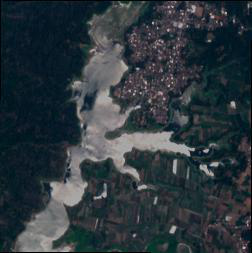

In [ ]:
Image.open("Water Bodies Dataset/Images/water_body_10.jpg")

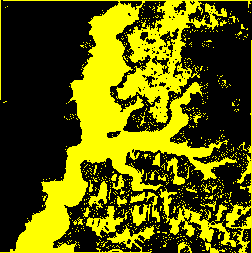

In [ ]:
mask =Image.open("Water Bodies Dataset/Masks/water_body_10.jpg")
mask = mask.convert('P')
mask.putpalette([
    0,0,0,
    255,255,0
])

mask

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

In [ ]:
root_dir = "Water Bodies Dataset"

In [ ]:
os.path.join(root_dir, "Images")

'Water Bodies Dataset/Images'

In [ ]:
sorted(os.listdir(os.path.join(root_dir, "Images")))[:5]

['water_body_1.jpg',
 'water_body_10.jpg',
 'water_body_100.jpg',
 'water_body_1000.jpg',
 'water_body_1002.jpg']

In [ ]:
class WaterDataset(Dataset):
  def __init__(self, root_dir, transforms=None):
    self.root_dir = root_dir
    self.transforms = transforms

    self.images = list(sorted(os.listdir(os.path.join(root_dir, "Images"))))
    self.masks = list(sorted(os.listdir(os.path.join(root_dir, "Masks"))))

  def __getitem__(self, index):
    flag = True
    img_path = os.path.join(self.root_dir, "Images", self.images[index])
    mask_path = os.path.join(self.root_dir, "Masks", self.masks[index])
    # Read image using PIL Image package
    img = Image.open(img_path).convert("RGB")
    # read mask image
    mask = Image.open(mask_path)
    # convert PIL image into numpy array
    mask = np.array(mask)
    # mask = cv2.resize(mask, (380, 423))
    obj_ids = np.unique(mask)
    # exclude 0th index, because 0th index is background color
    obj_ids = obj_ids[1:]
    # get binary mask only...
    # now it will set our mask image as either true or false
    # every color in mask except black i.e,
    # background will be true and bg will be given false
    masks = mask == obj_ids[:, None, None]
    target = {}
    # get bounding box
    num_objs = len(obj_ids) # number of persons in an image
    boxes = []
    for i in range(num_objs):
      try:
        # print("I is :",i, num_objs, masks.shape, index)
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])
      except BaseException as ex:
        print(ex)

    # type cast box list into a tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    # type cast mask into tensor
    masks = torch.as_tensor(masks, dtype=torch.uint8)

    image_id = torch.tensor([index])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.images)

In [ ]:
dataset = WaterDataset(root_dir)
dataset[0]

'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not

<ipython-input-26-461e4c49eb91>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  masks = mask == obj_ids[:, None, None]


IndexError: ignored

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
# FastRCNN is pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 82.2MB/s]


In [ ]:
NUM_CLASSES = 2
# number of input features for classifier
input_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, NUM_CLASSES)

In [ ]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [ ]:
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# mobilenet output channel is 1280

backbone.out_channels = 1280

anchor_gen = AnchorGenerator()
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7, sampling_ratio=2)
model = FasterRCNN(backbone, num_classes=2, rpn_anchor_generator=anchor_gen,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 54.8MB/s]


In [ ]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
def get_segmentation(num_classes):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  input_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(input_features, NUM_CLASSES)

  input_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  model.roi_heads.mask_predictor = MaskRCNNPredictor(input_features_mask,
                                                     hidden_layer,
                                                     NUM_CLASSES)
  return model

In [ ]:
%%shell
git clone https://github.com/pytorch/vision.git

cd vision
cp references/detection/utils.py ../
cp references/detection/engine.py ../
cp references/detection/coco_eval.py ../
cp references/detection/coco_utils.py ../
cp references/detection/transforms.py ../

Cloning into 'vision'...
remote: Enumerating objects: 345502, done.
remote: Counting objects: 100% (61734/61734), done.
remote: Compressing objects: 100% (1656/1656), done.
remote: Total 345502 (delta 60679), reused 60959 (delta 60033), pack-reused 283768
Receiving objects: 100% (345502/345502), 691.58 MiB | 35.91 MiB/s, done.
Resolving deltas: 100% (318530/318530), done.


In [ ]:
#import torchvision.transforms as T
import transforms as T

In [ ]:
def transformations(train):
  transforms = []
  transforms.append(T.PILToTensor())
  transforms.append(T.ConvertImageDtype(torch.float))
  # transforms.append(T.Resi ze(300,300))
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  return T.Compose(transforms)

In [ ]:
from engine import train_one_epoch, evaluate
import utils

In [ ]:
dataset = WaterDataset(root_dir, transformations(train=True))
test_dataset = WaterDataset(root_dir, transformations(train=False))

In [ ]:
indices = torch.randperm(len(dataset)).tolist()

In [ ]:
# in train_dataset we have 170-50 = 120 images
train_dataset = torch.utils.data.Subset(dataset, indices[:-50])
# in test_dataset we have 50 images
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

In [ ]:
data_loader_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_segmentation(NUM_CLASSES)
model.to(device)

params = [param for param in model.parameters() if param.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 75.7MB/s]


In [ ]:
epochs = 10

for epoch in range(epochs):
  train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not subscriptable
'bool' object is not

<ipython-input-29-461e4c49eb91>:27: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  masks = mask == obj_ids[:, None, None]


IndexError: ignored